# Modeling a Gas Network using JuMP and Plasmo
### Jordan Jalving & Victor Zavala

## Graph based Modeling (component based modeling)
Plasmo applies a graph-based abstraction to model interconnected systems using nodes and edges.  In this sense, models (e.g. JuMP models) can be associated with nodes and edges and then coupled by providing function handles (coupling functions) to nodes or edges within their respective graph.  The key to this abstraction is the use of subgraphs.  It is possible to set coupling functions for a node within the context of multiple graphs.  This allows general coupling formulations that can connect a node to its neighbors within the prescribed subgraph.

![title](13_pipe_sketch.png)

## Network Equations
Although our system of equations is described in terms of sets, we will implement them in terms of individual model components.

$\newcommand{\norm}[1]{\left\lvert#1\right\rvert}$
__Objective__ (Minimize system compressor cost; maximize gas delivery to all demands)

$
\min \varphi:=\int_{0}^T \left(\sum_{\ell \in \mathcal{L}_a}\alpha_{P}P(\tau) - \sum_{d \in \mathcal{D}}\alpha_{gas} f_{deliver}(\tau)\right)d\tau
$


__Isothermal Euler Equations__

$
\begin{align*}
      &\frac{\partial p_{\ell}(t,x)}{\partial t} + \frac{c^2}{A_{\ell}}\frac{\partial f_{\ell}(t,x)}{\partial x} = 0, \ \ \ell \in \mathcal{L}\\
      &\frac{\partial f_{\ell}(t,x)}{\partial t} + \frac{2c^2f_{\ell}(t,x)}{A_{\ell}p_{\ell}(t,x)}\frac{\partial f_{\ell}(t,x)}{\partial x} - \frac{c^2f_{\ell}(t,x)^2}{A_{\ell}p_{\ell}(t,x)^2}\frac{\partial p_{\ell}(t,x)}{\partial x}
          + A_{\ell}\frac{\partial p_{\ell}(t,x)}{\partial x} = -\frac{8c^2\lambda A_{\ell}}{\pi^2D_{\ell}^5}\frac{f_{\ell}(t,x)}{p_{\ell}(t,x)} \norm{f_{\ell}(t,x)}, \ \ \ell \in \mathcal{L}
    \end{align*}
$

__Compressor Equation__

$
\begin{align*}
&P_{\ell}(t)= c_p\cdot T\cdot f_{in,\ell}\left(\left(\frac{p_{in,\ell}(t)+\Delta p_{\ell}(t)}{p_{in,\ell}(t)}\right)^{\frac{\gamma-1}
{\gamma}}-1\right),\ell \in \mathcal{L}_a\\
\end{align*}
$

__Pipe Boundary Conditions__

$
\begin{align*}
&p_{\ell}(0,t)= p_{in,\ell}(t)+\Delta p_{\ell}(t),\ell \in \mathcal{L}_a\\
&p_{\ell}(0,t)= p_{in,\ell}(t),\ell \in \mathcal{L}_p\\
&p_{\ell}(L_{\ell},t)= p_{out,\ell}(t),\ell \in \mathcal{L}\\
\end{align*}
$

__Node Conservation__

$
\begin{align*}
&\sum_{\ell\in\mathcal{L}_n^{rec}}f_{out,\ell}(t)-\sum_{\ell \in\mathcal{L}_n^{snd}}f_{in,\ell}(t) +
\sum_{i\in\mathcal{S}_n}g_i(t) - \sum_{j\in \mathcal{D}_n}d_j^{gas}(t) = 0,\; n \in\mathcal{N}
\end{align*}
$

__Supply and Demand__

$
\begin{align*}
&f_{deliver,n}(t) \le f_{demand,n}(t),n \in \mathcal{D} \\
& \underline{s} \le g_n(t) \le \overline{s},n \in \mathcal{S}
\end{align*}
$

## Import JuMP and Ipopt

In [1]:
push!(LOAD_PATH,"/home/juser/JuliaBox/PlasmoShortCourse/src")
using JuMP
using Ipopt
using PyPlot
using Plasmo

## The usual physical property data

In [2]:
eps= 0.025  # pipe rugosity - [mm]
z= 0.80     # gas compressibility  - []
rhon=0.72   # density of air at normal conditions - [kg/m3]
R=8314.0    # universal gas constant [J/kgmol-K]
M=18.0      # gas molar mass [kg/kgmol]
pi=3.14     # pi
Tgas = 293.15    # reference temperature [K]
Cp = 2.34        # heat capacity @ constant pressure [kJ/kg-K]
Cv = 1.85        # heat capacity @ constant volume [kJ/kg-K]

#scaling factors
ffac=(1e+6*rhon)/(24*3600)                     # from scmx10-6/day to kg/s
ffac2=(3600)/(1e+4*rhon)                       # from kg/s to scmx10-4/hr
pfac=1e+5                                      # from bar to Pa
pfac2=1e-5                                     # from Pa to bar
dfac=1e-3                                      # from mm to m
lfac=1e+3;                                      # from km to m

#We will also use a global horizon variable!
global horizon = 24*3600;

In [3]:
include("gas_components.jl");

### *Notice that we do not use sets of links.  Each pipeline is its own component encapsulating its own variables and equations*

## Pipeline Models

### Setup our data for the pipeline

In [4]:
#pipeline data
diameter = 0.92
time_grid = 1:24
x_grid = 1:3
min_pressure = 1
max_pressure = 100
min_flow = 1
max_flow = 300

#compressor data
dp_min = 1
dp_max = 20
min_power = 1
max_power = 5000
comp_cost = 0.1;

#junction parameters
pressure_lower = 50
pressure_upper = 70

#demand parameters
gas_cost = -1000

#supply parameters
supply_cost = 0
fgen_lower = 0
fgen_upper = 600

n_supplies = 1
n_demands = 1
supply_limit = 300
node_lower_pressure = 50
node_upper_pressure = 70

### Set our data for the junctions, demand, and supply

In [5]:
#pdata = PipeData(pipe_length,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow) #pipe data
cdata = CompData(dp_min,dp_max,min_power,max_power,comp_cost) #compressor data
supply_node_data = NodeData(time_grid,n_supplies,fgen_upper,0,54,70,gas_cost,supply_cost)
demand_node_data = NodeData(time_grid,0,fgen_upper,n_demands,39,41,gas_cost,supply_cost)
junction_node_data = NodeData(time_grid,0,fgen_upper,0,34,70,gas_cost,supply_cost);

## Create the Plasmo Graph

In [6]:
#Create the Graph model and get the graph object from it
model = GraphModel()
graph = getgraph(model)

plasmo graph: ##1039
empty directed graph

## Create nodes and edges. Assign models

In [7]:
#add 14 gas nodes
for i = 1:14
    node = add_node!(model)
    if i == 1
        setmodel!(node,gasnode(supply_node_data))
    elseif i == 14
        setmodel!(node,gasnode(demand_node_data))
    else
        setmodel!(node,gasnode(junction_node_data))
    end
end

#Add the edges between them
for j = 1:13
    n_from = getnode(model,j)
    n_to = getnode(model,j+1)
    edge = add_edge!(model,n_from,n_to)
    if j == 1 || j == 13
        pdata = PipeData(300000,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow) #pipe data
        pipe_model = adiabaticpassivelink(pdata)
        #pipe_model = weymouthpassivelink(pdata)
        pipe_model = steadystatestart(pipe_model,pdata)
        setmodel!(edge,pipe_model)
    else
        pdata = PipeData(100000,diameter,time_grid,x_grid,min_pressure,max_pressure,min_flow,max_flow) #pipe data
        pipe_model = adiabaticactivelink(pdata,cdata)
        #pipe_model = weymouthactivelink(pdata,cdata)
        pipe_model = steadystatestart(pipe_model,pdata)
        setmodel!(edge,pipe_model)
    end
end

## Link the system

In [8]:
#Add the linking constraints
#Node Conservation at each node
for (index,node) in getnodes(model)
    @linkconstraint(model,graph,node,[t = time_grid], 0 == sum(in_edges(graph,node)[i][:fout][t] for i = 1:length(in_edges(graph,node))) -
        sum(out_edges(graph,node)[i][:fin][t] for i = 1:length(out_edges(graph,node))) + node[:total_supplied][t] - node[:total_delivered][t])
end

#Boundary conditions on each edge
for (index,edge) in getedges(model)
    @linkconstraint(model,graph,edge,[t = time_grid],edge[:pin][t] == getconnectedfrom(graph,edge)[:pressure][t])
    @linkconstraint(model,graph,edge,[t = time_grid],edge[:pout][t] == getconnectedto(graph,edge)[:pressure][t])
end

## Fix supply and demands

In [9]:
#Fix the demand at the last node
demand = getnode(graph,14)
d = getmodel(demand)
@constraint(d,[t = time_grid],d[:demand][1,t] == 42)

supply = getnode(graph,1)
s = getmodel(supply)
@constraint(s,[t = time_grid],s[:pressure][t] == 54);

## Solve the graph model

In [10]:
model.solver = IpoptSolver(tol = 1E-6)
solve(model,graph)

Creating flattened graph model...
Finished model instantiation

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    15831
Number of nonzeros in inequality constraint Jacobian.:       74
Number of nonzeros in Lagrangian Hessian.............:     5328

Total number of variables............................:     6017
                     variables with only lower bounds:     2904
                variables with lower and upper bounds:     2760
                     

## Look at the results

In [11]:
pressure_profile = Matrix(length(time_grid),0)
flow_profile = Matrix(length(time_grid),0)

graph = getgraph(model)
pipes = getedges(graph)
n_pipes = length(pipes)

#sort the edge indices
edges = sort(collect(keys(getedges(graph))))

for edge_index in edges
    pipe = getedge(graph,edge_index)
    px = pipe[:px]
    fx = pipe[:fx]
    pressure_profile = [pressure_profile getvalue(px[:,:])]
    flow_profile = [flow_profile getvalue(fx[:,:])]
end

x_plot = linspace(0,1700,length(x_grid)*13)

39-element LinSpace{Float64}:
 0.0,44.7368,89.4737,134.211,178.947,223.684,…,1565.79,1610.53,1655.26,1700.0

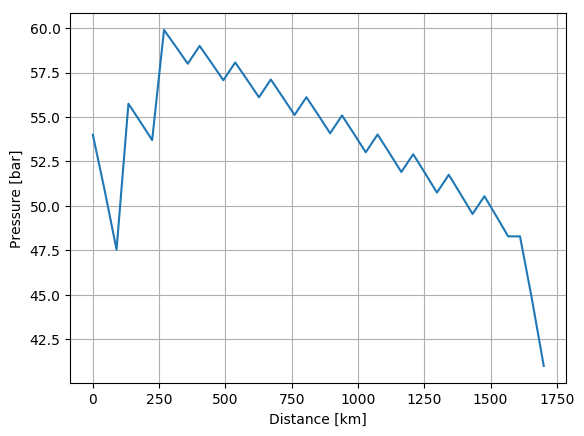

In [13]:
plot(x_plot,pressure_profile[1,:])
xlabel("Distance [km]")
ylabel("Pressure [bar]")
grid("on")

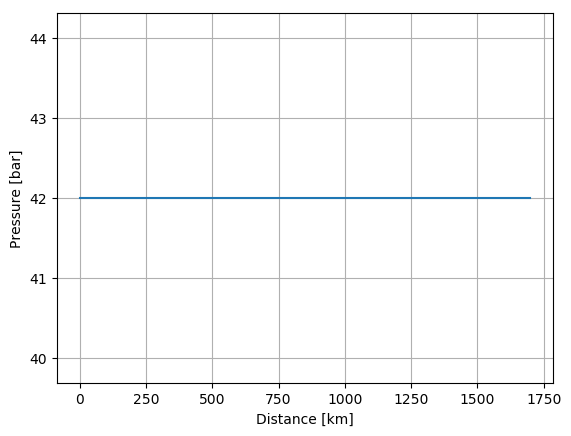

In [14]:
plot(x_plot,flow_profile[1,:])
xlabel("Distance [km]")
ylabel("Pressure [bar]")
grid("on")

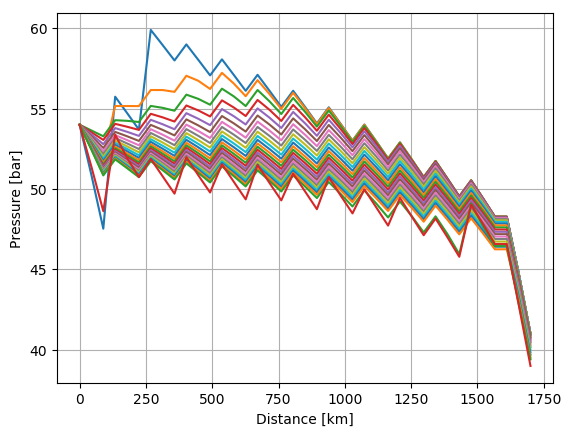

In [15]:
for t = time_grid
    plot(x_plot,pressure_profile[t,:])
end
xlabel("Distance [km]")
ylabel("Pressure [bar]")
grid("on")

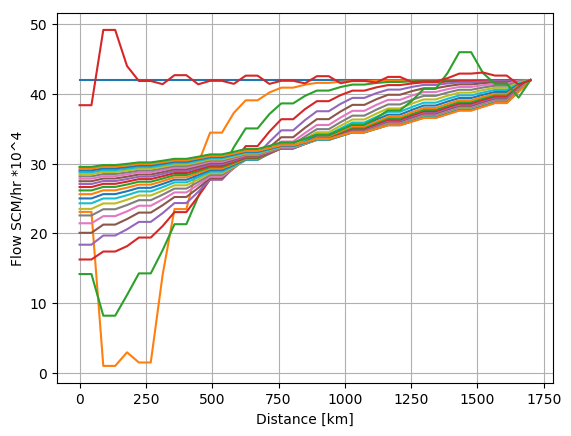

In [16]:
for t = time_grid
    plot(x_plot,flow_profile[t,:])
end
xlabel("Distance [km]")
ylabel("Flow SCM/hr *10^4")
grid("on")